In [65]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from finta import TA

In [71]:
# Import the dataset into a Pandas Dataframe of instrument of your choice
instrument_df = pd.read_csv(
    Path("./Resources/BTC-USD_5y.csv"), 
    index_col='Date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
instrument_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,7446.830078,7446.830078,7101.520020,7143.580078,7143.580078,3.226250e+09
2017-11-10,7173.729980,7312.000000,6436.870117,6618.140137,6618.140137,5.208250e+09
2017-11-11,6618.609863,6873.149902,6204.220215,6357.600098,6357.600098,4.908680e+09
2017-11-12,6295.450195,6625.049805,5519.009766,5950.069824,5950.069824,8.957350e+09
2017-11-13,5938.250000,6811.189941,5844.290039,6559.490234,6559.490234,6.263250e+09


In [76]:
instrument_df= instrument_df.rename(columns=str.lower)

In [77]:
# Creating empty Dataframe
df = pd.DataFrame()

In [78]:
# Create a function to find the optimal components for my trading algorithm
# Filter the date index and close columns
def trading_algo(short_window_input, long_window_input, training_period_input):
    signals_df = instrument_df.loc[:, ["close"]]

    # Use the pct_change function to generate  returns from close prices
    signals_df["Actual Returns"] = signals_df["close"].pct_change()

    # Drop all NaN values from the DataFrame
    signals_df = signals_df.dropna()


    short_window = short_window_input
    long_window =long_window_input

    # Generate the fast and slow simple moving averages (4 and 100 days, respectively)
    signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
    signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

    signals_df = signals_df.dropna()


    # Initialize the new Signal column
    signals_df['Signal'] = 0.0
    
    
    # When Actual Returns are greater than or equal to 0, generate signal to buy stock long
    signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

    # When Actual Returns are less than 0, generate signal to sell stock short
    signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = 0


    # Calculate the strategy returns and add them to the signals_df DataFrame
    signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

    # Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
    X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

    # Create the target set selecting the Signal column and assiging it to y
    y = signals_df['Signal']

    # Select the start of the training period
    training_begin = X.index.min()

    # Select the ending period for the training data with an offset of 3 months
    training_end = X.index.min() + DateOffset(months=training_period_input)


    # Generate the X_train and y_train DataFrames
    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]


    # Generate the X_test and y_test DataFrames
    X_test = X.loc[training_end+DateOffset(hours=1):]
    y_test = y.loc[training_end+DateOffset(hours=1):]


    # Scale the features DataFrames

    # Create a StandardScaler instance
    scaler = StandardScaler()

    # Apply the scaler model to fit the X-train data
    X_scaler = scaler.fit(X_train)

    # Transform the X_train and X_test DataFrames using the X_scaler
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    X_test_scaled

    # From SVM, instantiate SVC classifier model instance
    svm_model = svm.SVC()

    # Fit the model to the data using the training data
    svm_model = svm_model.fit(X_train_scaled, y_train)

    # Use the testing data to make the model predictions
    svm_pred = svm_model.predict(X_test_scaled)


    # Use a classification report to evaluate the model using the predictions and testing data
    svm_testing_report = classification_report(y_test, svm_pred)


    # Create a new empty predictions DataFrame.

    # Create a predictions DataFrame
    predictions_df = pd.DataFrame(index=X_test.index)

    # Add the SVM model predictions to the DataFrame
    predictions_df['Predicted'] = svm_pred

    # Add the actual returns to the DataFrame
    predictions_df['Actual Returns'] = signals_df["Actual Returns"]

    # Add the strategy returns to the DataFrame
    predictions_df['Strategy Returns'] = signals_df["Actual Returns"] * predictions_df["Predicted"]


  
    # Create the column names for the dataframe to find the optimal components for the algorithm. The column names will be generated by the for loop
    df[f'{short_window}_{long_window}_{training_period}'] = (1+predictions_df["Strategy Returns"]).cumprod()
    # Plot the actual returns versus the strategy returns
    #(1+predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(title= f"{short_window}, {long_window}, {training_period_input}")

In [79]:
# Create lists for our function to iterate through
short_window_list = [5,10,15,20,30,50]
long_window_list = [60,80,100,150,200]
training_period_list= [1,2,3,4,5,6,7,8]

In [80]:
#Create a for loop to find the optimal components for our algorithm
for short_window in short_window_list:
    for long_window in long_window_list:
        for training_period in training_period_list:
            trading_algo(short_window, long_window, training_period)

C:\Users\chaim\Anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chaim\Anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chaim\Anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chaim\Anaconda3\env

In [81]:
# Return the optimal combo for windows and training period

optimal_combo = df.columns[(df==df.iloc[-1].max()).iloc[-1]]
optimal_combo = optimal_combo[0]
print (optimal_combo)



30_150_7


In [82]:
# Parse out the 3 paramaters for the model
split_string = optimal_combo.split("_",2)
short_win = int(split_string[0])
long_win = int(split_string[1])
train_period = int(split_string[2])
print(short_win, long_win, train_period)


30 150 7


In [83]:
# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
# Filter the date index and adj close columns
signals_df = instrument_df.loc[:, ["close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()


signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_win).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_win).mean()
bollinger_df = TA.BBANDS(instrument_df)
macd_df = TA.MACD(instrument_df)

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(bollinger_df)
display(macd_df)

,close,Actual Returns,SMA_Fast,SMA_Slow
Date,,,,
2018-04-08,7023.520020,0.016268,7992.887305,11004.340216
2018-04-09,6770.729980,-0.035992,7923.044971,11005.357481
2018-04-10,6834.759766,0.009457,7831.582633,11008.538546
2018-04-11,6968.319824,0.019541,7757.022624,11015.326879
2018-04-12,7889.250000,0.132160,7713.502637,11024.191944


,BB_UPPER,BB_MIDDLE,BB_LOWER
Date,,,
2017-11-09,NaN,NaN,NaN
2017-11-10,NaN,NaN,NaN
2017-11-11,NaN,NaN,NaN
2017-11-12,NaN,NaN,NaN
2017-11-13,NaN,NaN,NaN
...,...,...,...
2021-12-24,51859.403106,48562.748047,45266.092988
2021-12-25,52000.056620,48615.798633,45231.540646
2021-12-26,52040.557088,48627.143164,45213.729241


,MACD,SIGNAL
Date,,
2017-11-09,NaN,NaN
2017-11-10,NaN,NaN
2017-11-11,NaN,NaN
2017-11-12,NaN,NaN
2017-11-13,NaN,NaN
...,...,...
2021-12-24,-1484.572522,-2218.672262
2021-12-25,-1258.392748,-2026.616360
2021-12-26,-1036.559745,-1828.605037


In [84]:
signals_df = pd.concat([bollinger_df, signals_df, macd_df], axis=1)

In [85]:
signals_df = signals_df.dropna()

In [86]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1
# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = 0

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,BB_UPPER,BB_MIDDLE,BB_LOWER,close,Actual Returns,SMA_Fast,SMA_Slow,MACD,SIGNAL,Signal
Date,,,,,,,,,,
2018-04-08,9359.837385,7663.089502,5966.341619,7023.520020,0.016268,7992.887305,11004.340216,-615.959228,-626.085624,1.0
2018-04-09,9189.696466,7555.952515,5922.208563,6770.729980,-0.035992,7923.044971,11005.357481,-603.262862,-621.521071,0.0
2018-04-10,8979.421552,7451.226489,5923.031426,6834.759766,0.009457,7831.582633,11008.538546,-581.333016,-613.483460,1.0
2018-04-11,8780.406564,7363.218994,5946.031424,6968.319824,0.019541,7757.022624,11015.326879,-546.872336,-600.161236,1.0
2018-04-12,8567.594843,7313.700488,6059.806134,7889.250000,0.132160,7713.502637,11024.191944,-440.176995,-568.164388,1.0


,BB_UPPER,BB_MIDDLE,BB_LOWER,close,Actual Returns,SMA_Fast,SMA_Slow,MACD,SIGNAL,Signal
Date,,,,,,,,,,
2021-12-24,51859.403106,48562.748047,45266.092988,50822.19531,0.000741,50849.384246,51738.108152,-1484.572522,-2218.672262,1.0
2021-12-25,52000.056620,48615.798633,45231.540646,50429.85938,-0.007720,50621.223569,51807.667839,-1258.392748,-2026.616360,0.0
2021-12-26,52040.557088,48627.143164,45213.729241,50809.51563,0.007528,50529.215235,51879.675131,-1036.559745,-1828.605037,1.0
2021-12-27,52030.041060,48624.159766,45218.278472,50640.41797,-0.003328,50390.059897,51935.707605,-864.435585,-1635.771146,0.0
2021-12-28,51793.719417,48478.362695,45163.005974,47588.85547,-0.060259,50068.073178,51975.458673,-963.158844,-1501.248686,0.0


In [87]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame

display(signals_df.head())
display(signals_df.tail())


,BB_UPPER,BB_MIDDLE,BB_LOWER,close,Actual Returns,SMA_Fast,SMA_Slow,MACD,SIGNAL,Signal,Strategy Returns
Date,,,,,,,,,,,
2018-04-08,9359.837385,7663.089502,5966.341619,7023.520020,0.016268,7992.887305,11004.340216,-615.959228,-626.085624,1.0,NaN
2018-04-09,9189.696466,7555.952515,5922.208563,6770.729980,-0.035992,7923.044971,11005.357481,-603.262862,-621.521071,0.0,-0.035992
2018-04-10,8979.421552,7451.226489,5923.031426,6834.759766,0.009457,7831.582633,11008.538546,-581.333016,-613.483460,1.0,0.000000
2018-04-11,8780.406564,7363.218994,5946.031424,6968.319824,0.019541,7757.022624,11015.326879,-546.872336,-600.161236,1.0,0.019541
2018-04-12,8567.594843,7313.700488,6059.806134,7889.250000,0.132160,7713.502637,11024.191944,-440.176995,-568.164388,1.0,0.132160


,BB_UPPER,BB_MIDDLE,BB_LOWER,close,Actual Returns,SMA_Fast,SMA_Slow,MACD,SIGNAL,Signal,Strategy Returns
Date,,,,,,,,,,,
2021-12-24,51859.403106,48562.748047,45266.092988,50822.19531,0.000741,50849.384246,51738.108152,-1484.572522,-2218.672262,1.0,0.000741
2021-12-25,52000.056620,48615.798633,45231.540646,50429.85938,-0.007720,50621.223569,51807.667839,-1258.392748,-2026.616360,0.0,-0.007720
2021-12-26,52040.557088,48627.143164,45213.729241,50809.51563,0.007528,50529.215235,51879.675131,-1036.559745,-1828.605037,1.0,0.000000
2021-12-27,52030.041060,48624.159766,45218.278472,50640.41797,-0.003328,50390.059897,51935.707605,-864.435585,-1635.771146,0.0,-0.003328
2021-12-28,51793.719417,48478.362695,45163.005974,47588.85547,-0.060259,50068.073178,51975.458673,-963.158844,-1501.248686,0.0,-0.000000


<AxesSubplot:xlabel='Date'>

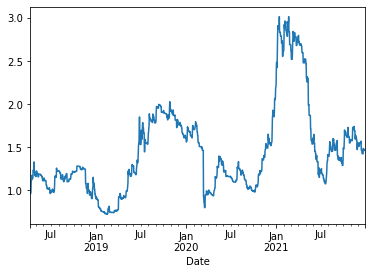

In [88]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

In [89]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[["close", "Actual Returns", "Strategy Returns", 'SMA_Fast', 'SMA_Slow', "MACD", "SIGNAL", "BB_UPPER", "BB_MIDDLE", "BB_LOWER"]].shift().dropna()

# Review the DataFrame
X

,close,Actual Returns,Strategy Returns,SMA_Fast,SMA_Slow,MACD,SIGNAL,BB_UPPER,BB_MIDDLE,BB_LOWER
Date,,,,,,,,,,
2018-04-10,6770.729980,-0.035992,-0.035992,7923.044971,11005.357481,-603.262862,-621.521071,9189.696466,7555.952515,5922.208563
2018-04-11,6834.759766,0.009457,0.000000,7831.582633,11008.538546,-581.333016,-613.483460,8979.421552,7451.226489,5923.031426
2018-04-12,6968.319824,0.019541,0.019541,7757.022624,11015.326879,-546.872336,-600.161236,8780.406564,7363.218994,5946.031424
2018-04-13,7889.250000,0.132160,0.132160,7713.502637,11024.191944,-440.176995,-568.164388,8567.594843,7313.700488,6059.806134
2018-04-14,7895.959961,0.000851,0.000851,7701.040983,11032.593344,-351.032255,-524.737961,8393.639893,7275.092480,6156.545068
...,...,...,...,...,...,...,...,...,...,...
2021-12-24,50784.539060,0.044337,0.000000,51031.325261,51662.006459,-1791.613309,-2402.197198,51620.332627,48481.673438,45343.014249
2021-12-25,50822.195310,0.000741,0.000741,50849.384246,51738.108152,-1484.572522,-2218.672262,51859.403106,48562.748047,45266.092988
2021-12-26,50429.859380,-0.007720,-0.007720,50621.223569,51807.667839,-1258.392748,-2026.616360,52000.056620,48615.798633,45231.540646


In [90]:
y = signals_df['Signal'] 

# Review the value counts
y.value_counts()

1.0    721
0.0    640
Name: Signal, dtype: int64

In [91]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2018-04-10 00:00:00


In [92]:
# Select the ending period for the training data with an offset of X months
training_end = X.index.min() + DateOffset(months=train_period)

# Display the training end date
print(training_end)

2018-11-10 00:00:00


In [93]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
y_train.count()
X_train.count()

close               215
Actual Returns      215
Strategy Returns    215
SMA_Fast            215
SMA_Slow            215
MACD                215
SIGNAL              215
BB_UPPER            215
BB_MIDDLE           215
BB_LOWER            215
dtype: int64

In [94]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
#X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]
#y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
display(X_test.count())


close               1144
Actual Returns      1144
Strategy Returns    1144
SMA_Fast            1144
SMA_Slow            1144
MACD                1144
SIGNAL              1144
BB_UPPER            1144
BB_MIDDLE           1144
BB_LOWER            1144
dtype: int64

In [101]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)



In [102]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)


In [103]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)
# Print the classification report

print(svm_testing_report)


              precision    recall  f1-score   support

         0.0       0.49      0.32      0.39       539
         1.0       0.54      0.70      0.61       605

    accuracy                           0.52      1144
   macro avg       0.51      0.51      0.50      1144
weighted avg       0.52      0.52      0.51      1144



In [104]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)
# Add the SVM model predictions to the DataFrame
predictions_df["predicted_signal"] = svm_pred
predictions_df

,predicted_signal
Date,
2018-11-11,1.0
2018-11-12,1.0
2018-11-13,1.0
2018-11-14,1.0
2018-11-15,1.0
...,...
2021-12-24,1.0
2021-12-25,1.0
2021-12-26,1.0


In [105]:
# Add the actual returns to the DataFrame
predictions_df["Actual Returns"] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df["Strategy Returns"] = predictions_df["Actual Returns"] * predictions_df["predicted_signal"]
predictions_df["Entry/Exit"] = predictions_df["predicted_signal"].diff()
predictions_df["Adj Close"] = signals_df["close"]
predictions_df.tail(20)

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,predicted_signal,Actual Returns,Strategy Returns,Entry/Exit,Adj Close
Date,,,,,
2018-11-11,1.0,0.000320,0.000320,NaN,6411.270020
2018-11-12,1.0,-0.006239,-0.006239,0.0,6371.270020
2018-11-13,1.0,-0.001849,-0.001849,0.0,6359.490234
2018-11-14,1.0,-0.097671,-0.097671,0.0,5738.350098
2018-11-15,1.0,-0.015740,-0.015740,0.0,5648.029785


,predicted_signal,Actual Returns,Strategy Returns,Entry/Exit,Adj Close
Date,,,,,
2021-12-24,1.0,0.000741,0.000741,0.0,50822.19531
2021-12-25,1.0,-0.007720,-0.007720,0.0,50429.85938
2021-12-26,1.0,0.007528,0.007528,0.0,50809.51563
2021-12-27,1.0,-0.003328,-0.003328,0.0,50640.41797
2021-12-28,1.0,-0.060259,-0.060259,0.0,47588.85547


<AxesSubplot:xlabel='Date'>

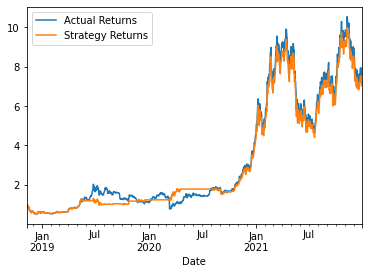

In [106]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()
# Baseline with 6 months training data and new SMAs
